# Notebook tutorial


This notebook contains a tutorial of how to create synthetic spectral cubes of a bowshock model using the tools provided by the BowshockPy package. As will be shown here, importing BowshockPy classes in your custom scripts provide a more flexible usage than just running BowshockPy from the terminal. 

As an example, this notebook shows how to obtain a synthetic spectral cube, moments maps, and position-velocity diagrams of two redshifted bowshocks of the same molecular jet. In particular, we will model the emission from the CO(J=3-2) transition.

We will need to import four classes from BowshockPy and follow these steps:
1. Create the bowshock model with **BowshockModel**: This class contains all the equations of an analytic momentum-conserving bowshock model. It can be instantiated using the model parameters as input arguments, and the model can be visualized with _get_modelplot_ method.
2. Project the bowshock model with **ObsModel**: This class contains all the equations needed to project the bowshock model (the morphology will be projected in the plane of the sky, the kinematics along the line of sight). You will need to provide some parameters that depend on the observer (as the inclination angle and the systemic velocity) in order to instantiate the class. The method _get_obsmodelplot_ allows to visualize the projected morphology and kinematics of the bowshock model.
3. Compute the masses of the spectral cube with **MassCube**: This class computes the amount of mass of the bowshock shell that corresponds to each pixel and velocity channel of the spectral cube. It also contains the the _plot_channel_ and _plot_channels_ methods for the visualization of the channels maps.
4. Compute the column densities, opacities, and intensities with **CubeProcessing**: This class contains all the tools needed to obtain the intensities from the masses at each pixel and channel. By default, BowshockPy computes the opacities and performs the radiative transfer of the emission from low-J rotational transitions of a linear molecule (assuming Local Thermodynamic Equilibrium, negligible population of vibrational excited states, and negligible centrifugal distortions). However, the user can apply their own implementation of their custom molecular transition and radiative transfer. This class also contains methods that allows to convolve with a Gaussian beam, obtain moments maps, position-velocity diagrams, and to save the results in fits format.

In this tutorial we also include three appendices that describe additional functionality of BowshockPy:
- Appendix A: We describe a shortcut usin CubeProcessing in order to obtain all the specified outputs at once.
- Appendix B: We explain how an advance user can apply their own implementation of their a molecular transition and radiative transfer.
- Appendix C: We explain how an advance user can implement their own models and use BowshockPy to obtain the intensity maps.

For a detailed description of the functioning, instantiation input parameters, attributes, and methods of each class, see the [API reference](https://bowshockpy.readthedocs.io/en/latest/api/index.html)



# Table of Contents
- [1. Creation of the bowshock models through **BowshockModel** class](##bowshockmodel)
- [2. Projection of the bowshocks with **ObsModel** class](##obsmodel)
- [3. Computation of the masses in the spectral cube with **MassCube** class](##masscube)
- [4. Obtaining intensity maps with **CubeProcessing** class](##cubeprocessing)
  - [4.1 Combination of bowshock model cubes](###combination)
  - [4.2. Computation of column densities](###coldens)
  - [4.3. Computation of opacities](###opacities)
  - [4.4. Computation of intensities](###intensities)
  - [4.5. Position velocity diagram and moment maps](###pvmom)
- [Appendix A: Computing all CubeProcessing outputs at once](##once)
- [Appendix B: Custom computation of intensities](##customtrans)
- [Appendix C: Custom model](##custommodel)

In [1]:
import numpy as np

from astropy import units as u

import matplotlib.pyplot as plt

from bowshockpy import BowshockModel, ObsModel, MassCube, CubeProcessing
from bowshockpy import utils as ut
from bowshockpy import __version__

In [2]:
print(f"Using BowshockPy v{__version__}")

Using BowshockPy v0.3.1


In [3]:
# Let's store all the outputs of this notebook in this folder:
savefolder = "models/notebook_tutorial/"
ut.make_folder(savefolder)

# Cubes and maps in fits format will be saved in
ut.make_folder(f"{savefolder}fits/")

<a id="bowshockmodel"></a>
## 1. Creation of the bowshocks through **BowshockModel** class

In this example, we aim to create synthetic observations of two consecutive bowshocks of the same jet. We first define the parameters of both bowshock model and instantiate the **BowshockModel** class

### Bowshock 1

In [4]:
# Distance to the source in pc
distpc = 300

# name of the model
modelname1 =  f"Bowshock1"

# Characteristic lenght scale of the bowshock [km] 
L0_1 = (0.4 * distpc * u.au).to(u.km).value

# distance from the source to the internal working surface [km]
zj_1 = (4 * distpc * u.au).to(u.km).value 

# velocity of the internal working surface [km/s]
vj_1 = 100                                   

# velocity of the ambient [km/s]
va_1 = 5                                      

# velocity at which the material is ejected sideways [km/s]
v0_1 = 15                                    

# total mass of the bowshock shell [Msun]
mass_1 = 0.0002                              

# final radius of the bowhsock [km]
rbf_obs_1 = (0.7 * distpc * u.au).to(u.km).value

model1 = BowshockModel(
    L0=L0_1,
    zj=zj_1,
    vj=vj_1,
    va=va_1,
    v0=v0_1,
    mass=mass_1,
    rbf_obs=rbf_obs_1,
    distpc=distpc,
    )

We have access to some useful parameters from the instantiation of **BowshockModel**

In [5]:
print(
f"""
Bowshock 1:
Density of the ambient: {model1.rhoa_gcm3:.2e} g/cm^3
Mass rate of material ejected sideways from the internal working surface: {model1.mp0_solmassyr:.2e} Msun/yr
Mass rate of material incorporated into the bowshock surface: {model1.mpamb_f_solmassyr:.2e} Msun/yr
"""
)


Bowshock 1:
Density of the ambient: 3.92e-19 g/cm^3
Mass rate of material ejected sideways from the internal working surface: 1.26e-06 Msun/yr
Mass rate of material incorporated into the bowshock surface: 1.83e-06 Msun/yr



We can obtain a graphical representation of the two models with _get_modelplot_ method

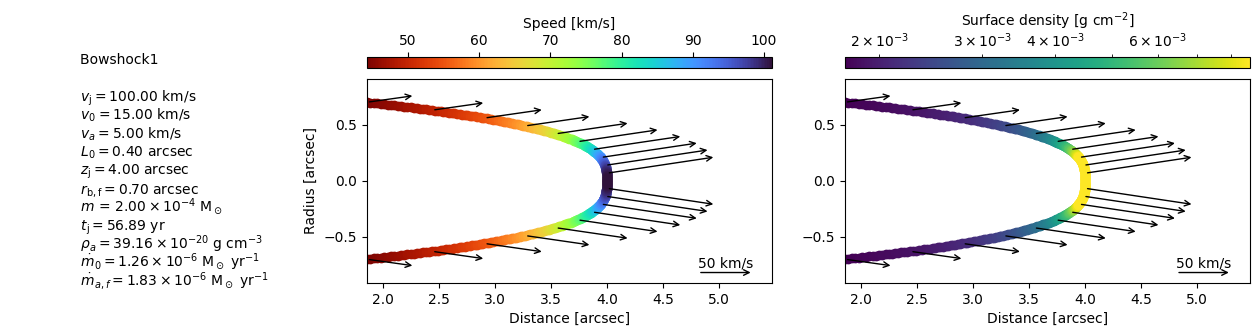

In [6]:
model_plot1 = model1.get_modelplot(
    modelname=modelname1,
    v_arrow_ref=50,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
)

model_plot1.plot(
    max_plotdens=np.percentile(model_plot1.surfdenss_gcm2, 70),
)

# You can save the figure with savefig method
model_plot1.savefig(f"{savefolder}{modelname1}_model.pdf")

### Bowshock 2

We follow the same procedure with the second bowshock

In [7]:
modelname2 =  f"Bowshock2"
L0_2 = (0.33 * distpc * u.au).to(u.km).value
zj_2 = (3 * distpc * u.au).to(u.km).value 
vj_2 = 95
va_2 = 5
v0_2 = 10
mass_2 = 0.00015
rbf_obs_2 = (0.55 * distpc * u.au).to(u.km).value

model2 = BowshockModel(
    L0=L0_2,
    zj=zj_2,
    vj=vj_2,
    va=va_2,
    v0=v0_2,
    mass=mass_2,
    rbf_obs=rbf_obs_2,
    distpc=distpc,
    )

In [8]:
print("""
Bowshock 2:
Density of the ambient: {model2.rhoa_gcm3:.2e} g/cm^3
Mass rate of material ejected sideways from the internal working surface: {model2.mp0_solmassyr:.2e} Msun/yr
Mass rate of material incorporated into the bowshock surface: {model2.mpamb_f_solmassyr:.2e} Msun/yr
""")


Bowshock 2:
Density of the ambient: {model2.rhoa_gcm3:.2e} g/cm^3
Mass rate of material ejected sideways from the internal working surface: {model2.mp0_solmassyr:.2e} Msun/yr
Mass rate of material incorporated into the bowshock surface: {model2.mpamb_f_solmassyr:.2e} Msun/yr



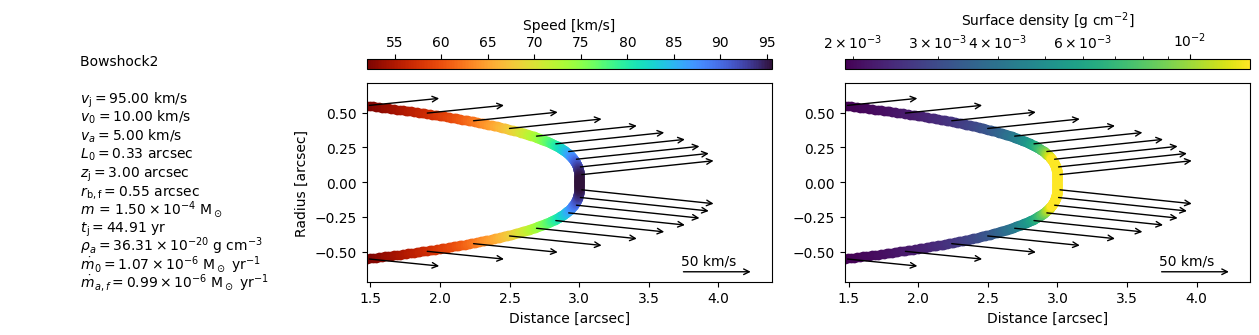

In [9]:
model_plot2 = model2.get_modelplot(
    modelname=modelname2,
    v_arrow_ref=50,
#    figsize=(16,3),
#    textbox_widthratio=0.7,
 )
model_plot2.plot(
    max_plotdens=np.percentile(model_plot2.surfdenss_gcm2, 70),
)

# For comparison with the first model, you can put the same x-axis limits as for the first model by:
# model_plot2.axs[0].set_xlim([*model_plot1.axs[0].get_xlim()])
# model_plot2.axs[1].set_xlim([*model_plot1.axs[1].get_xlim()])

# You can save the figure with savefig method
model_plot2.savefig(f"{savefolder}{modelname2}_model.pdf")

<a id="obsmodel"></a>
## 2. Projection of the bowshocks with **ObsModel** class 

Once we have created the bowshock models, we want to projected their morphology onto the plane-of-sky and their velocity field along the line-of-sight velocity. We can do this using ObsModel class. In this example, we will use the same position angle and inclination for both bowshocks

### Bowshock 1

In [10]:
# inclination angle of the bowshock axis with the line-of-sight. Use
# innclination angles > 90 for redshifted jets, <90 for blueshifted jets
# [degrees]
i_deg = 110

# Position angle of the bowshock [degrees]
pa_deg = -10

# Systemic velocity of the source
vsys = 5

model_obs1 = ObsModel(
    model=model1, # instantiation of BowshockModel
    i_deg=i_deg, 
    pa_deg=pa_deg,
    vsys=vsys, 
    )


We can obtain a visualization of the projected morphology and kinematics of the bowshock model using the _get_modelplot_ method 

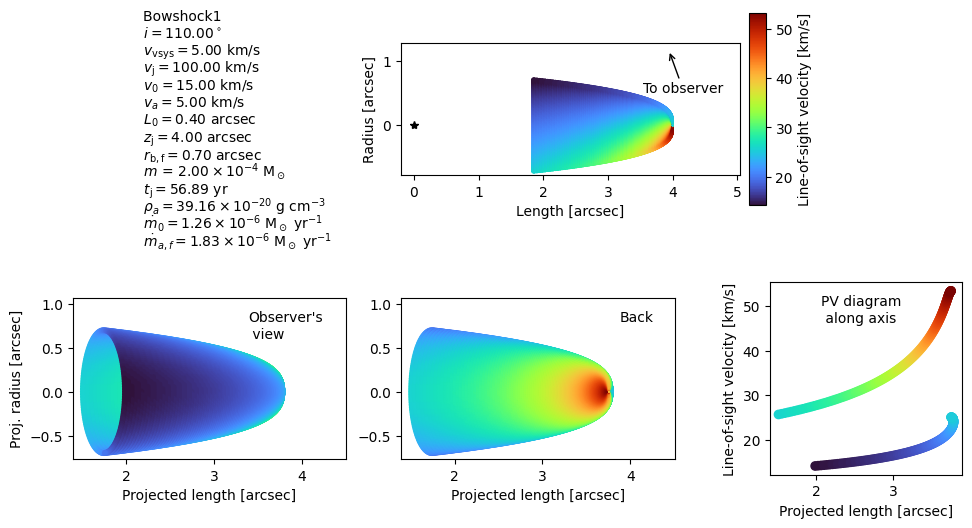

In [11]:
model_obs_plot = model_obs1.get_obsmodelplot(
    modelname=modelname1,
    figsize=(12, 6),
    )

model_obs_plot.plot()
# Make your custom modifications on the plot here
# For example:
# model_obs_plot.axs[0].set_xlim([0, 5])

model_obs_plot.savefig(figname=f"{savefolder}{modelname1}_modelproj.jpg", dpi=300)

### Bowshock 2

We do the same for bowshock 2

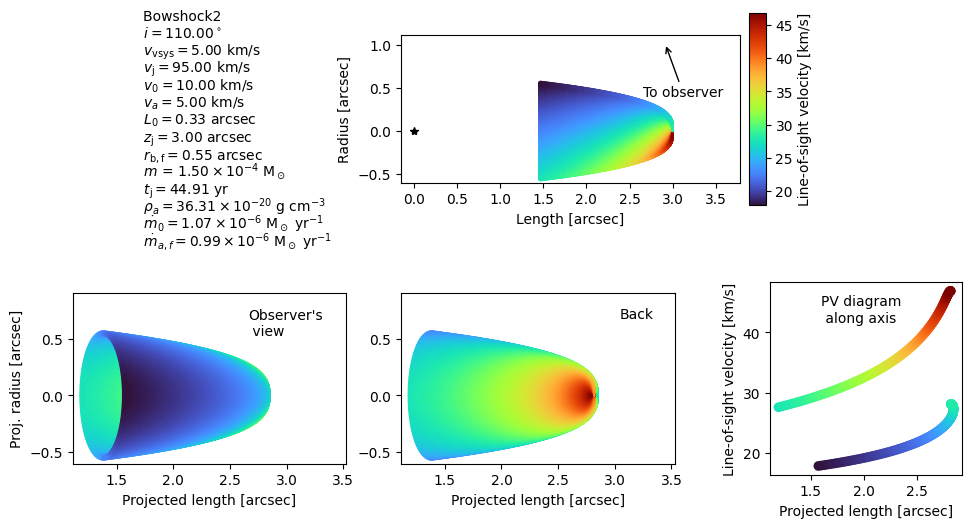

In [12]:
model_obs2 = ObsModel(
    model2,
    i_deg=i_deg, 
    pa_deg=pa_deg,
    vsys=vsys, 
    )

model_obs_plot2 = model_obs2.get_obsmodelplot(
    modelname=modelname2,
    figsize=(12, 6),
    )

model_obs_plot2.plot()
# Make your custom modifications on the plot here
# model_obs_plot.axs[0].set_xlim([0, 5])
model_obs_plot.savefig(figname=f"{savefolder}{modelname2}_modelproj.jpg", dpi=300)

<a id="masscube"></a>
## 3. Computation of the masses in the spectral cube with **MassCube**

Let's now compute the masses in each pixel and each channel of the spectral cube for each of the bowshocks. **You can use the position velocity diagrams of the last two figures in order to choose an appropiate range of velocities covered by the spectral cubes (vhc0 and vchf) and the physical size (xpmax) of the channel maps**. Be aware that, due to the thermal+turbulent line of sight velocity dispersion (controled by vt parameter), the velocity range covered by the spectral cube should be higher than the one displayed in the position-velocity diagrams shown in the last figures. Otherwise, bowshock model will not be fully covered (velocity disperions are not included in the last two figures)

In [13]:
# Number of model points along the z-axis direction
nzs = 800

# Number of azimuthal angle phi for each z-axis point to calculate the bowshock solution
nphis = 400

# Number of spectral channel maps
nc = 80

# Central velocity of the first channel map [km/s]
vch0 = 10

# Central velocity of the last channel map [km/s]. Set to None if chanwidth is used.
vchf = 60

# Width of the velocity channel [km/s]. If chanwidth>0, then vch0<vchf, if
# chanwidth<0, then vch0>vchf. Set to None if vchf is used.
chanwidth = None

# Number of pixels in the right ascension axis
nxs = 150

# Number of pixels in the declination axis
nys = 150

# Physical size of the channel maps along the x axis [arcsec]
xpmax = 5

# Thermal+turbulent line-of-sight velocity dispersion [km/s] 
# If thermal+turbulent line-of-sight velocity dispersion is smaller than the
# instrumental spectral resolution, vt should be the spectral resolution. It
# can be also set to a integer times the channel width, in this case it would be
# a string [e.g., "3xchannel"]
vt = "3xchannel"

# Set to true in order to perform a Cloud in Cell interpolation. If False,
# nearest neighbour point sampling will be performed [True/False]
cic = True

# Neighbour channel maps around a given channel map with vch will stop being
# populated when their difference in velocity with respect to vch is higher than
# this factor times vt. The lower the factor, the quicker will be the code, but
# the total mass will be underestimated. If vt is not None, compare the total
# mass of the output cube with the 'mass' parameter that the user has defined
tolfactor_vt = 3

# Reference pixel [[int, int] or None]
# Pixel coordinates (zero-based) of the source, i.e., the origin from which the
# distances are measured. The first index is the R.A. axis, the second is the
# Dec. axis.
refpix = [75, 15]

# Verbose messages about the computation? [True/False]
verbose = True


### Bowshock 1

In [14]:
model_cube1 = MassCube(
    model_obs1,
    nphis=nphis,
    xpmax=xpmax,    
    vch0=vch0, 
    vchf=vchf,
    chanwidth=chanwidth,
    nzs=nzs,
    nc=nc,
    nxs=nxs,
    nys=nys, 
    refpix=refpix, 
    cic=cic,
    vt=vt,
    tolfactor_vt=tolfactor_vt,
    verbose=verbose,
    )

model_cube1.makecube()


Computing masses in the spectral cube...
  0──────────────────────────────────────────────────)100.0% | 103/114s
Checking total mass consistency...

Mass consistency test passed: The input total mass of the bowshock model
coincides with the total mass of the cube.



You can inspect individual channel maps with *_plot_channel_* method

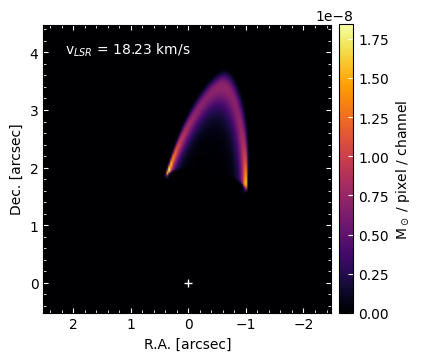

In [15]:
chan = 13
model_cube1.plot_channel(
    chan=chan,
    savefig=f"{savefolder}{modelname1}_channel{chan}.pdf"
    )

You can use the _plot_channels_ method in order to visualize several channel maps

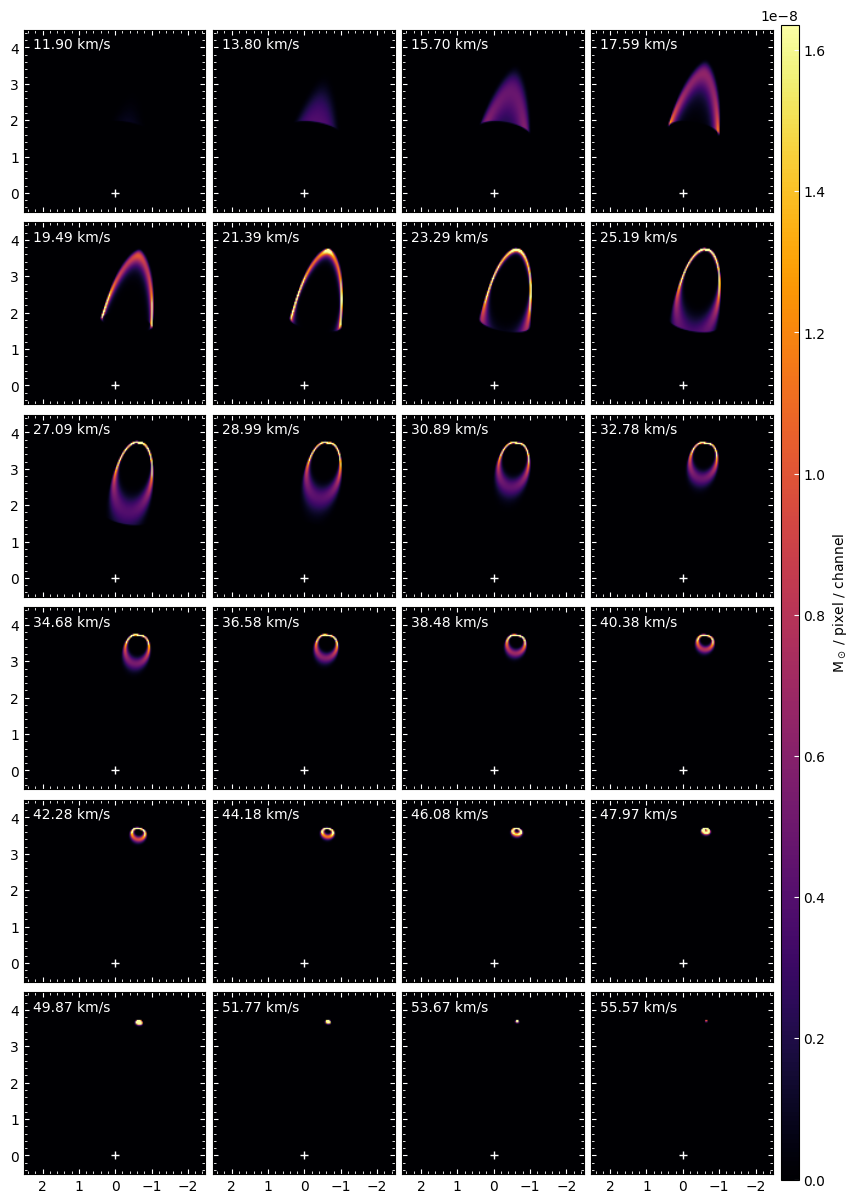

In [16]:
model_cube1.plot_channels(
    nrow=6, ncol=4, 
    vmax=np.percentile(model_cube1.cube, 99.9),
    savefig=f"{savefolder}{modelname1}_channels.pdf",
    )

### Bowshock 2

We set the same parameters for the second bowshock, so we can later combine both models using **CubeProcessing** class

In [17]:
model_cube2 = MassCube(
    model_obs2,
    nphis=nphis,
    xpmax=xpmax,    
    vch0=vch0, 
    vchf=vchf,
    chanwidth=chanwidth,
    nzs=nzs,
    nc=nc,
    nxs=nxs,
    nys=nys, 
    refpix=refpix, 
    cic=cic,
    vt=vt,
    tolfactor_vt=tolfactor_vt,
    verbose=verbose,
    )

model_cube2.makecube()


Computing masses in the spectral cube...
  0──────────────────────────────────────────────────)100.0% | 97/92s
Checking total mass consistency...

Mass consistency test passed: The input total mass of the bowshock model
coincides with the total mass of the cube.



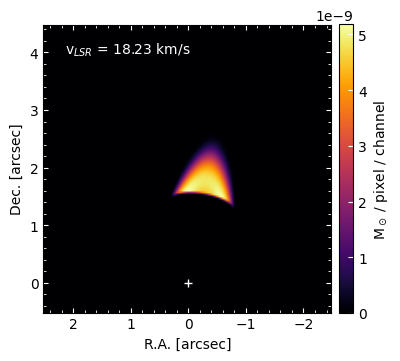

In [18]:
chan = 13
model_cube2.plot_channel(
    chan=chan,
    savefig=f"{savefolder}{modelname2}_channel{chan}.pdf"
    )

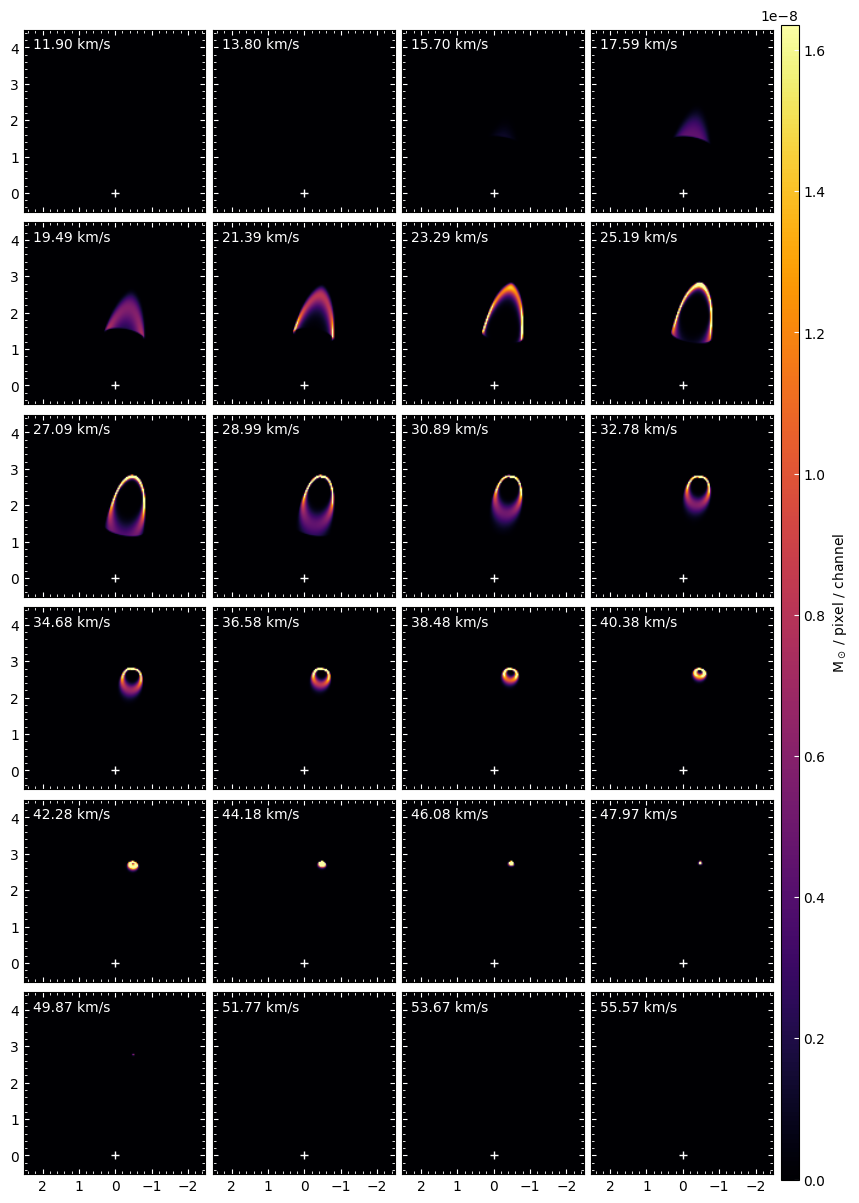

In [19]:
model_cube2.plot_channels(
    nrow=6, ncol=4, 
    vmax=np.percentile(model_cube1.cube, 99.9),
    savefig=f"{savefolder}{modelname2}_channels.pdf",
    )

<a id="cubeprocessing"></a>
## 4. Obtaining intensity maps with **CubeProcessing** class

We will use now **CubeProcessing** class to combine both cubes and perform the radiative transfer in order to obtain the intensities of the CO(3-2) transition. Also, would be able to obtain the moments and position-velocity diagrams. All the cubes and images can be save fits format and be open for further inspection with casaviewer, CARTA, or ds9.

In [20]:
# Source coordinates [deg, deg] 
ra_source_deg, dec_source_deg = 84.095, -6.7675

# Upper level of the CO rotational transition
J = 3

# Frequency of the transition [GHz]
nu = 345.79598990

# Emitting molecule abundance with respect to the molecular hydrogen
abund = 8.5 * 10**(-5)

# Mean molecular mass per hydrogen molecule, taking into account helium and
# metals that are heavier but less abundant than H2
meanmolmass = 2.8

# Permanent dipole moment [Debye]
mu = 0.112

# Excitation temperature [K]
Tex = 100

# Background temperature [K]
Tbg = 2.7

# Beam size [arcsec]
bmaj, bmin = (0.2, 0.15)

# Beam position angle [degrees]
pabeam = +30

# Spectral cubes in offset or sky coordinates? ["offset" or "sky"]
coordcube = "offset"

# Standard deviation of the noise of the map, before convolution. Set
# to None if maxcube2noise is used [Jy/beam]
sigma_beforeconv = 0.025

# Standard deviation of the noise of the map, before convolution, relative to
# the maximum pixel in the cube. The actual noise will be computed after
# convolving. This parameter would not be used if sigma_beforeconve is not
# None.
maxcube2noise = 0.07

<a id="combination"></a>
### 4.1 Combination of bowshock model cubes

The first step is to combine both bowshock model cubes. We can do this with passing a list of all the MassCube instances (in our case, model_cube1 and model_cube2) to CubeProcessing 

In [21]:
# astropy units are optional, and any units of the right quantity would work. If
# you use a float instead, you should give parameters in the specific units
# described in the comments from the cell above (see also input parameters from
# the documentation).
cubes_proc = CubeProcessing(
    [model_cube1, model_cube2], # we want to combine both models
    modelname="notebook_tutorial",
    J=J,
    nu=nu * u.GHz, 
    abund=abund,
    meanmolmass=meanmolmass,
    mu=mu * u.Debye,
    Tex=Tex * u.K,
    Tbg=Tbg * u.K,
    coordcube=coordcube,
    ra_source_deg=ra_source_deg,
    dec_source_deg = dec_source_deg,
    bmin=bmin,
    bmaj=bmaj,
    pabeam=pabeam,
    papv=model_cube1.pa_deg,
    sigma_beforeconv=sigma_beforeconv,
    maxcube2noise=maxcube2noise,
)

Let's check that the cubes with the masses of each bowshock have been combined in one single cube. We can visualize the masses with _plot_channel_ method. The input "m", indicates you are interested in plotting the masses, which is the only cube computed so far

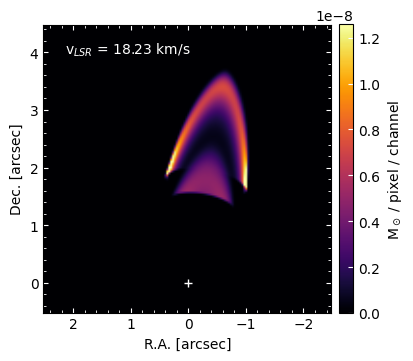

In [23]:
cube_key = "m"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    savefig=f"{savefolder}channel{chan}.pdf",
    vmax=np.percentile(cubes_proc.cubes[cube_key][chan], 99.9)
    )

<a id="coldens"></a>
### 4.2 Computation of coulmn densities

In this example, we will go through the steps to compute the intensities of the CO(3-2) transition. First, lets compute the total column densities (H2 plus heavier components).

In [24]:
cubes_proc.calc_Ntot()


Computing column densities...
The column densities have been calculated (Ntot cube)



We can inspect a particular channel with _plot_channel_ method

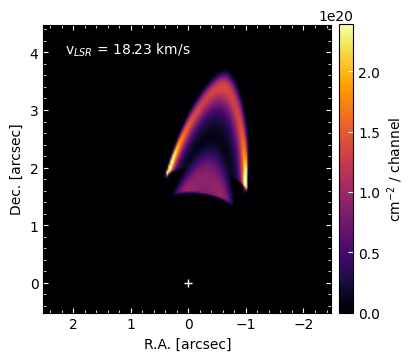

In [25]:
cube_key = "Ntot"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf",
    vmax=np.percentile(cubes_proc.cubes[cube_key][chan], 99.9)
    )

Let's now compute the CO (our emitting molecule) column densities 

In [26]:
cubes_proc.calc_Nmol()


Computing column densities of the emitting molecule...
The column densities of the emitting molecule have been calculated (Nmol cube)



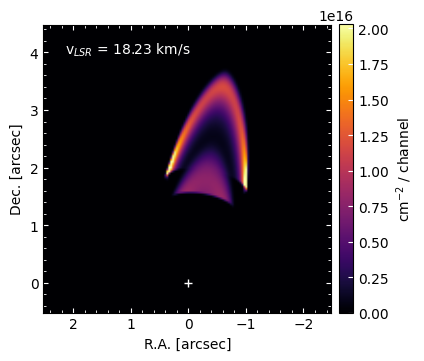

In [27]:
cube_key = "Nmol"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    vmax=np.percentile(cubes_proc.cubes[cube_key][chan], 99.9),
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf"
    )

<a id="opacities"></a>
### 4.3 Computation of opacities

In [28]:
cubes_proc.calc_tau()


Computing opacities...
The opacities have been calculated (tau cube)



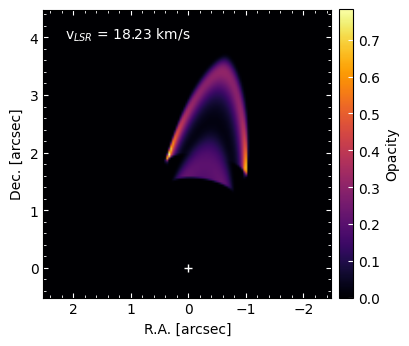

In [29]:
cube_key = "tau"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf",
    )

<a id="intensities"></a>
### 4.4 Computation of intensities

In [30]:
cubes_proc.calc_I()


Computing intensities...
The intensities have been calculated (I cube)



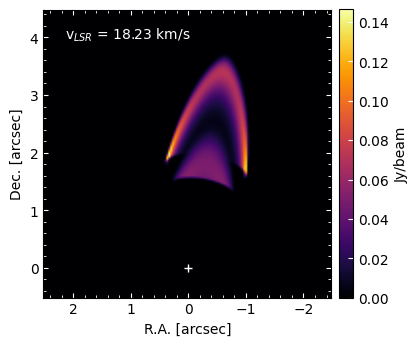

In [31]:
cube_key = "I"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf",
    )

Note that although the units are Jy/beam because we provided a beam size (if bmaj and bmin parameters would have been None, the intensity units would have been Jy/arcsec^2). However, the model is not convolved yet. In order to perform the convolution with the beam, we should use the __convolve__ method

In [32]:
cubes_proc.convolve(ck="I")


Convolving I... 
  0──────────────────────────────────────────────────)100.0% | 1/1s

I_c cube has been created by convolving I cube with a Gaussian kernel of
size [4.50, 6.00] pix and PA of 30.00deg



Let us inspect the convolved cube. Note that we should now use the label "I_c" to plot the cube of the convolved intesities 

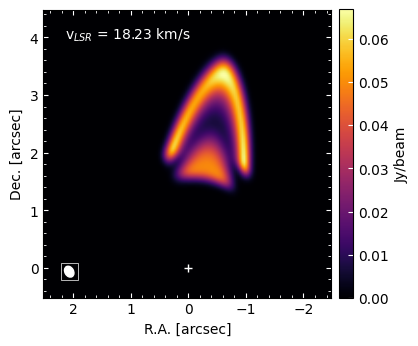

In [33]:
cube_key = "I_c"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    add_beam=True,
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf",
    )

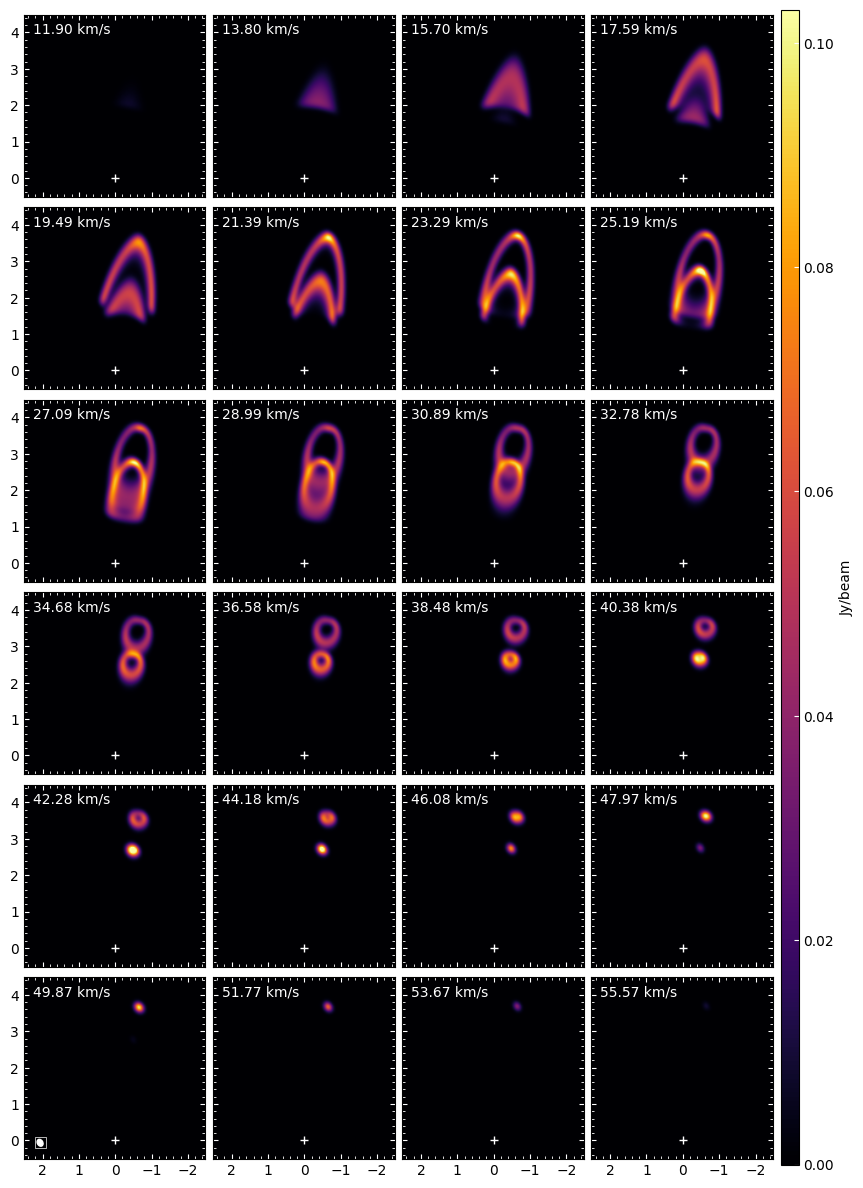

In [34]:
cubes_proc.plot_channels(
    ck="I_c",
    vmax=np.percentile(cubes_proc.cubes["I_c"], 99.99),
    nrow=6, ncol=4, 
    add_beam=True,
    savefig=f"{savefolder}{cube_key}_channels.pdf",
    )

#### Add noise and convolve

Additionally, you can add Gaussian noise to your channel maps by using _add_noise_ method. Lets add noise to the intensity cube and then convolve.

In [35]:
cubes_proc.add_noise(ck="I")
cubes_proc.convolve(ck="I_n")


Adding noise to I...

I_n cube has been created by adding Gaussian noise to I cube


Convolving I_n... 
  0──────────────────────────────────────────────────)100.0% | 1/1s

I_nc cube has been created by convolving I_n cube with a Gaussian kernel of
size [4.50, 6.00] pix and PA of 30.00deg


The rms of the convolved image is 0.0031746 Jy/beam



The label of the cube of the intensities with noise and convolved is "I_nc". Let's inspect it

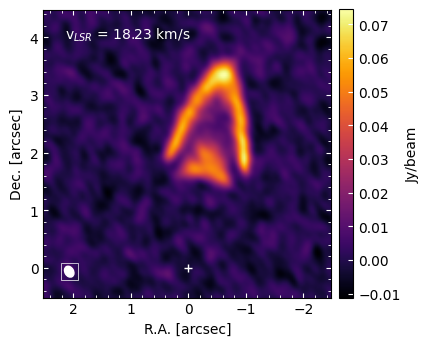

In [36]:
cube_key = "I_nc"
chan = 13

cubes_proc.plot_channel(
    ck=cube_key,
    chan=chan,
    add_beam=True,
    savefig=f"{savefolder}{cube_key}_channel{chan}.pdf",
    )

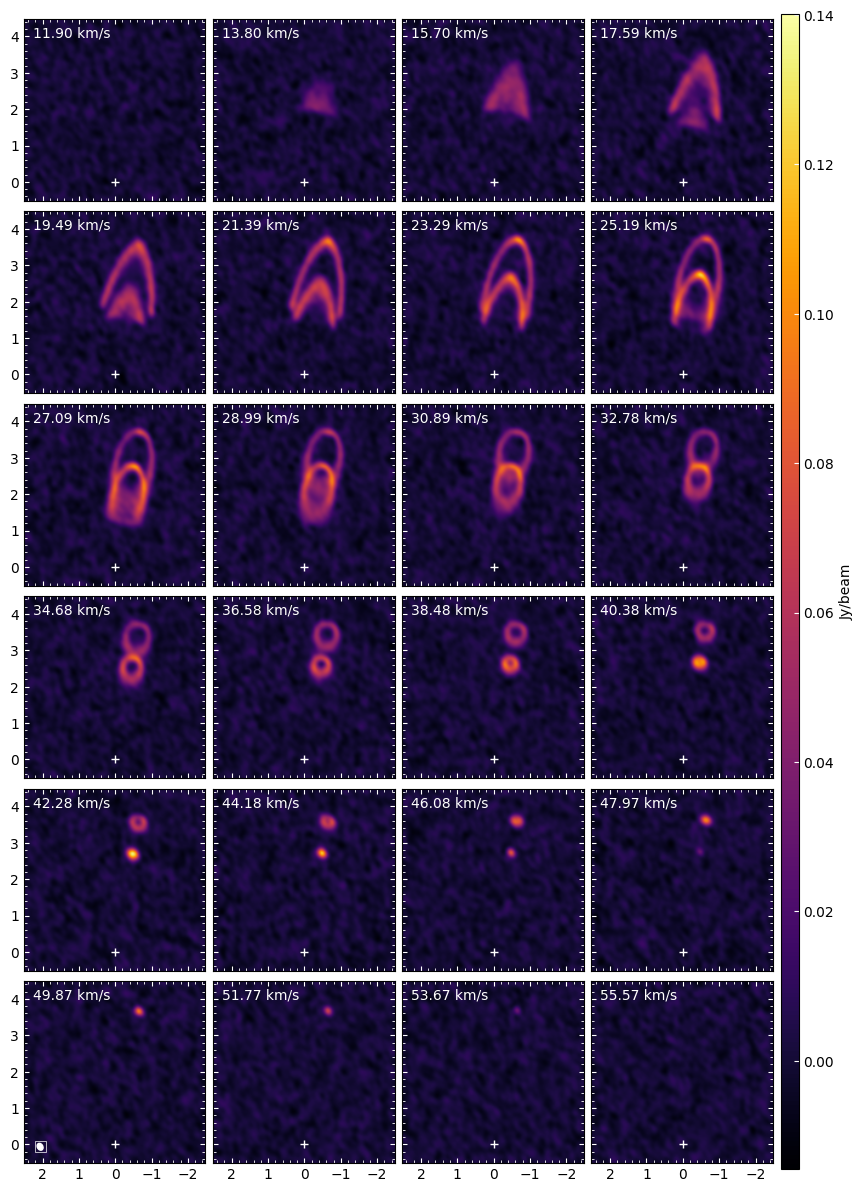

In [37]:
cube_key = "I_nc"

cubes_proc.plot_channels(
    ck=cube_key,
    nrow=6, ncol=4, 
    # vmin=-0.005,
    # vcenter=(0.07-0.005)/2,
    # vmax=0.07,
    add_beam=True,
    savefig=f"{savefolder}{cube_key}_channels.pdf",
    )

One can inspect the cubes computed so far and stored in cubes_proc:

In [38]:
cubes_proc.cubes.keys()

dict_keys(['m', 'Ntot', 'Nmol', 'tau', 'I', 'I_c', 'I_n', 'I_nc'])

The next table summarize the meaning of the cube labels and the units 

| Quantity                         | Cube label           | Unit
| :--------------------------------|:-------------------:|:--------------:
| Mass                             | m                   | solar mass
| Intensity                        | I                   | Jy/beam
| Column density                   | Ntot                | cm-2
| Emitting molecule column density | Nmol                 | cm-2
| Opacities                        | tau                 |


and the labels for the operations performed to the cubes 



| Operation  | Cube label
|:-----------|:----------------:
| add_source | s
| add_noise  | n
| convolve   | c
| rotate     | r

the operation "rotate" will be performed internally before computing the position velocity diagram

**Note**: CubeProcessing can compute directly the intensities using calc_I, without the need to run previously calc_Nmol and calc_tau methods. If calc_I is run before explicitely computing the CO column densities or the opacities, they will be computed internally and stored in _cubes_ attribute.

You can save any cube stored in the CubeProcessing instance with _savecube_ method. For example:

In [39]:
cube_key = "I_nc"
cubes_proc.savecube(
    ck=cube_key,
    fitsname=f"{savefolder}fits/{cube_key}.fits"
    )

models/notebook_tutorial/fits/I_nc.fits saved


<a id="pvmom"></a>
### 4.5 Position-velocity and moment maps

Let's now compute the position velocity diagram and moment images for some spectral cubes

#### Position velocity diagram


Rotatng I_c in order to compute the PV diagram...

I_cr cube has been created by rotating I_c cube an angle 80 deg to
compute the PV-diagram

models/notebook_tutorial/fits/I_cr_pv.fits saved


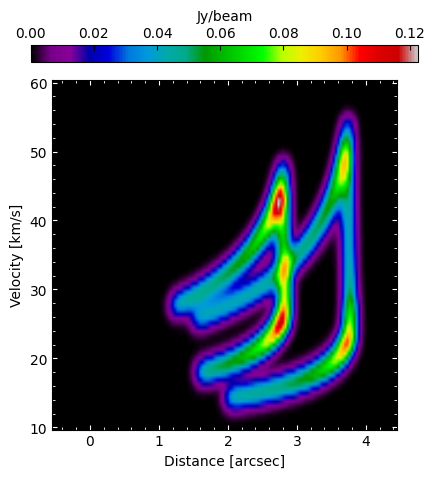

In [40]:
cube_key = "I_c"
cubes_proc.plotpv(
    ck=cube_key,
    halfwidth=2,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_pv.fits"
    )


Rotatng I_nc in order to compute the PV diagram...

I_ncr cube has been created by rotating I_nc cube an angle 80 deg to
compute the PV-diagram

models/notebook_tutorial/fits/I_ncr_pv.fits saved


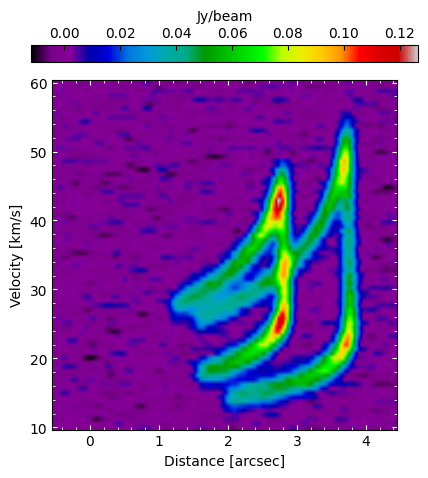

In [41]:
cube_key = "I_nc"
cubes_proc.plotpv(
    ck=cube_key,
    halfwidth=2,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_pv.fits"
    )

#### Moment 0

models/notebook_tutorial/fits/I_nc_mom0.fits saved


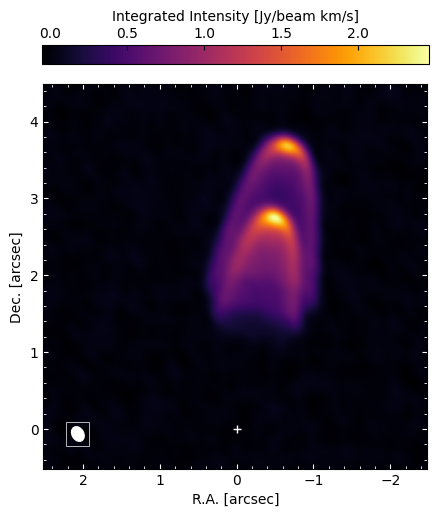

In [42]:
cube_key = "I_nc"
cubes_proc.plotmom0(
    ck=cube_key,
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_mom0.fits"
    )


#### Maximum intensity

models/notebook_tutorial/fits/I_nc_maxintens.fits saved


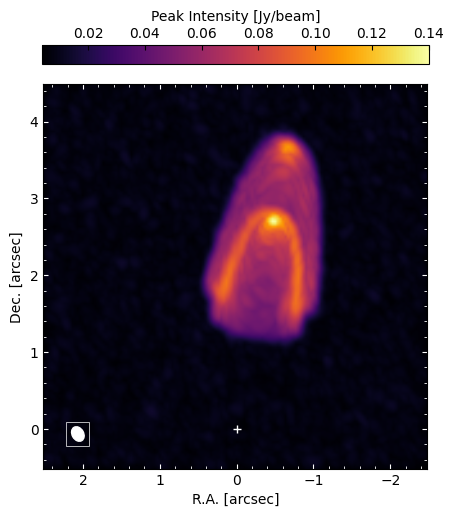

In [43]:
cube_key = "I_nc"
cubes_proc.plotmaxintens(
    ck=cube_key,
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_maxintens.fits"
    )


#### Moment 1

models/notebook_tutorial/fits/I_c_mom1.fits saved


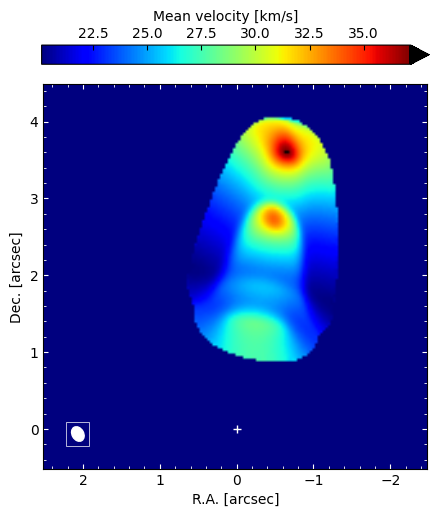

In [44]:
cube_key = "I_c"
cubes_proc.plotmom1(
    ck=cube_key,
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_mom1.fits"
    )

You can control your sigma clipping with mom1clipping argument, which is useful for your noisy maps (with key "I_nc")

models/notebook_tutorial/fits/I_nc_mom1.fits saved


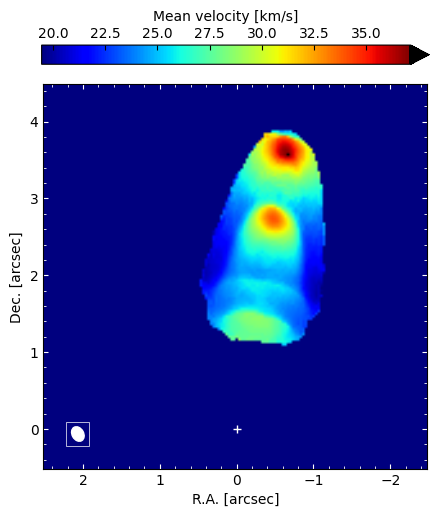

In [45]:
cube_key = "I_nc"
cubes_proc.plotmom1(
    ck=cube_key,
    mom1clipping="5xsigma",
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_mom1.fits"
    )


#### Moment 2

models/notebook_tutorial/fits/I_c_mom2.fits saved


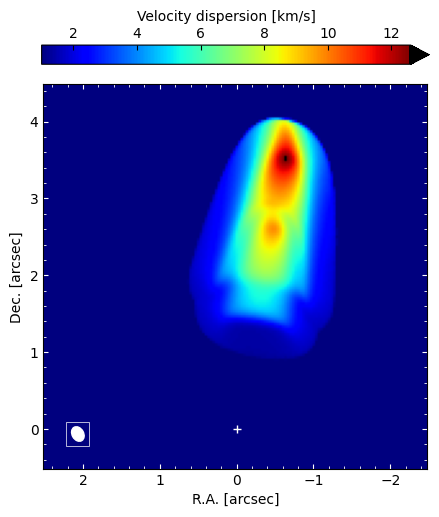

In [46]:
cube_key = "I_c"
cubes_proc.plotmom2(
    ck=cube_key,
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_mom2.fits"
    )

models/notebook_tutorial/fits/I_nc_mom2.fits saved


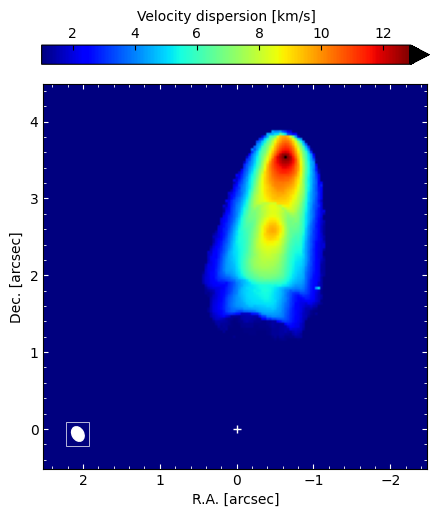

In [47]:
cube_key = "I_nc"
cubes_proc.plotmom2(
    ck=cube_key,
    mom2clipping="4xsigma",
    add_beam=True,
    savefits=True,
    fitsname=f"{savefolder}fits/{cube_key}_mom2.fits"
    )




Computing moments and the PV-diagram along the jet axis



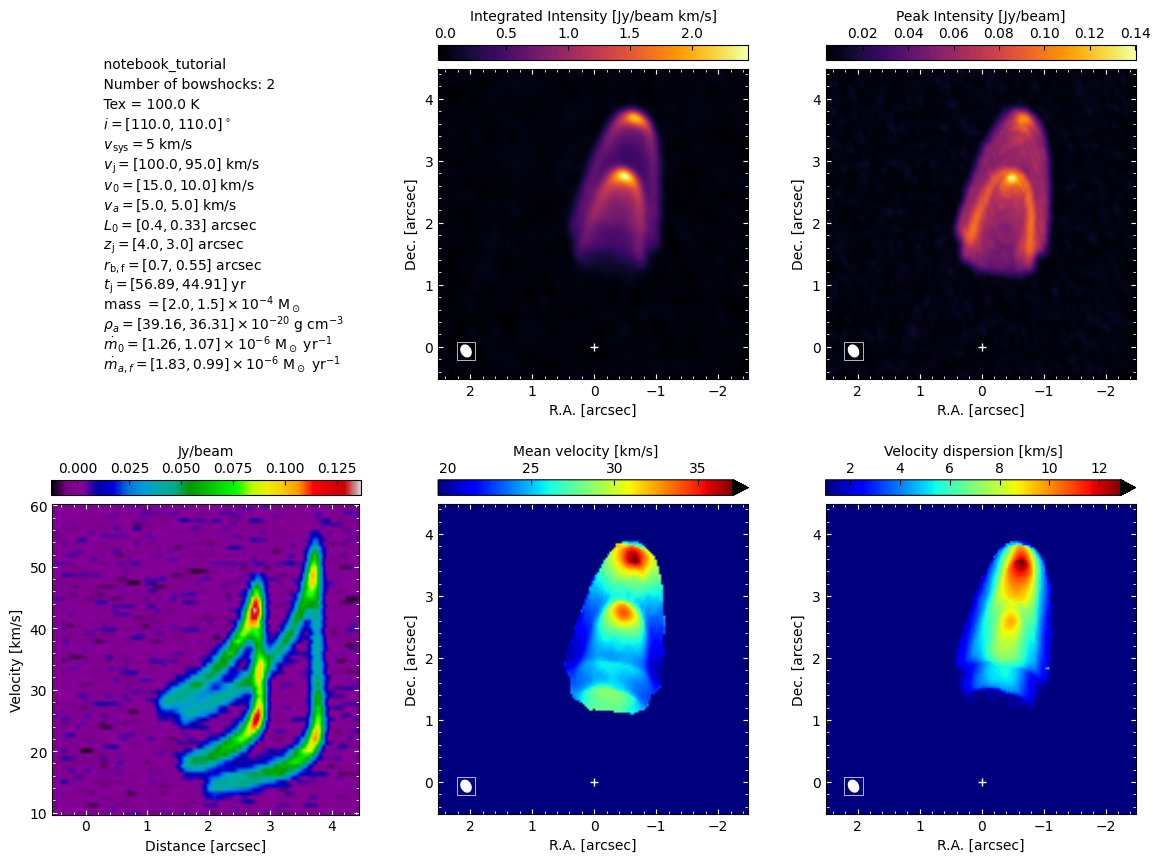

In [48]:
cubes_proc.momentsandpv_and_params("I_nc", mom1clipping="5xsigma", mom2clipping="4xsigma", add_beam=True)

<a id="once"></a>
## Appendix A: Computing all CubeProcessing output at once

In section 4, for didactic purposes, we used CubeProcessing, following the entire process step by step until we obtained the intensity maps. Alternatively, you can use as a shortcut the method _calc_ of CubeProcessing in order to calculate the desired outputs only. The input of _calc_ should be a dictionary, where the keys are the desired quantities and the values should be a list of strings indicating the operations to be performed. 

These are the available quantities of the spectral cubes:

- "mass": Total mass of molecular hydrogen in solar mass
- "total_column_density": Total (H2 + heavier components) column density in cm-2.
- "emitting_molecule_column_density": Column density of the emitting molecule in cm-2.
- "intensity": Intensity in Jy/beam.
- "tau": Opacities.

The values of the dictionary are lists of strings indicating the operations to be performed over the cube. These are the available operations:

- "add_source": Add a point source at the reference pixel
- "add_noise": Add gaussian noise, defined by maxcube2noise parameter.
- "convolve": Convolve with a gaussian defined by the parameters bmaj, bmin, and pabeam.
- "moments_and_pv": Computes the moments 0, 1, 2, the maximum intensity and the PV diagram.

The operations will be performed folowing the order of the strings in the list (from left to right). The list can be left empty if no operations are desired.


In [49]:
outcubes = {
    "intensity": ["add_noise", "convolve", "moments_and_pv"],
    "opacity": [],
    "total_column_density": [],
    "emitting_molecule_column_density": [],
    "mass": [],
    }

cubes_proc.calc(outcubes)
cubes_proc.savecubes()


models/notebook_tutorial/fits/I_nc.fits saved
models/notebook_tutorial/fits/tau.fits saved
models/notebook_tutorial/fits/Ntot.fits saved
models/notebook_tutorial/fits/Nmol.fits saved
models/notebook_tutorial/fits/m.fits saved


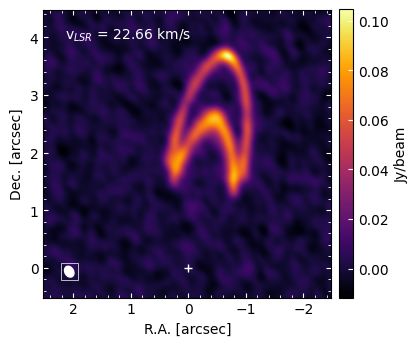

In [50]:
cubes_proc.plot_channel(ck="I_nc", chan=20, add_beam=True)



Computing moments and the PV-diagram along the jet axis



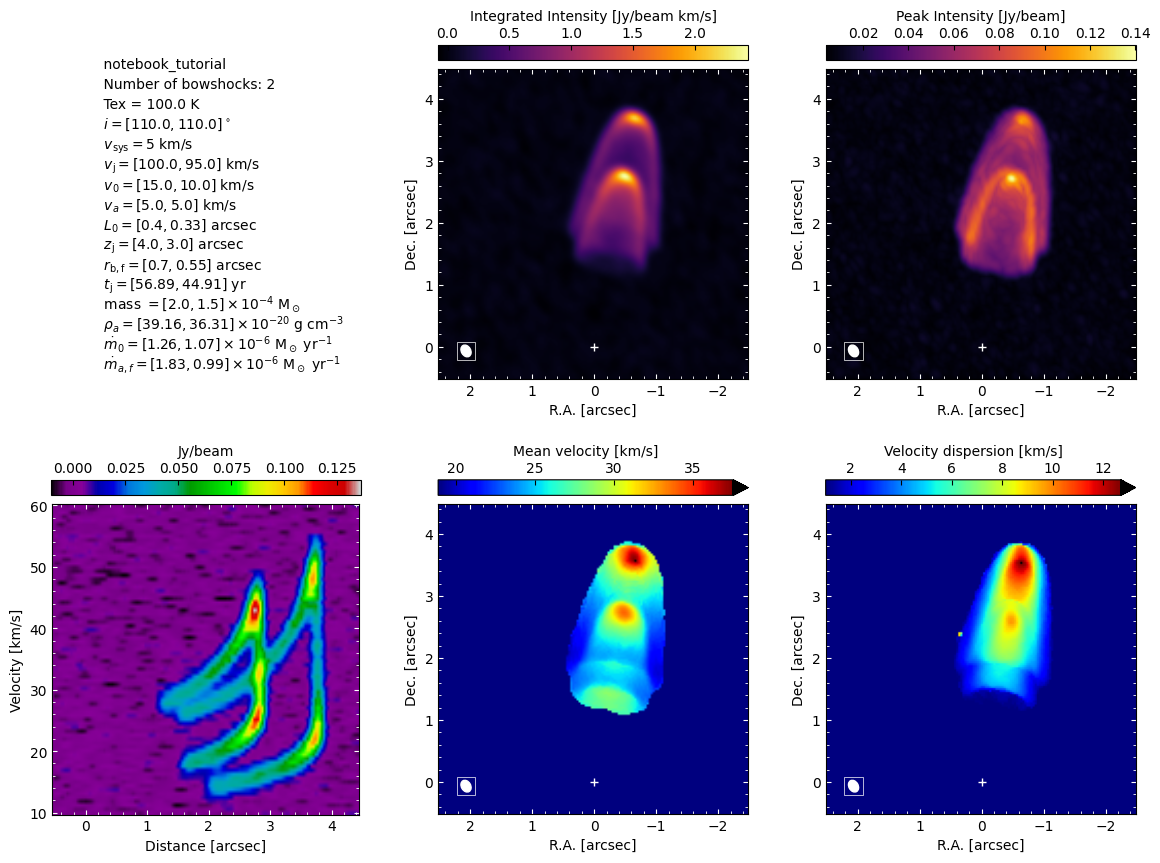

In [51]:
cubes_proc.momentsandpv_and_params("I_nc", mom1clipping="5xsigma", mom2clipping="4xsigma", add_beam=True)

<a id="customtrans"></a>
## Appendix B: Custom computation of intensities

BowshockPy, by default, is able to compute the intensities of a rotational transition of a linear molecule under this assumptions:
- Negligible population of excitated vibrational levels
- Negligible centrifugal distortions of the molecule.
- Local Thermodynamic Equilibrium. 

If you need a custom model the molecular transition or a different radiative transfer, you can implement them and use the column densities in order to derive the intensities. Alternatively, CubeProcessing accepts two custom functions:
- tau_custom_function(dNmoldv): Compute the opacities from the column densities per velocity bin
- Inu_custom_function(tau): Custom function to perform the radiative transfer from the opacities

In the following, we are going to implement an example of custom functions and pass them to CubeProcessing. Particularly, we will account for centrifugal distortion and assume optically thin emission in the radiative transfer.

In [52]:
import bowshockpy.radtrans as rt
import astropy.constants as const
import astropy.units as u


# Define the functions that you think are useful for your modelling
def Ej(j, B0, D0):
    """
    Energy state of a rotational transition of a linear molecule, taking
    into account the first order centrifugal distortion

    Parameters
    ----------
    j : int
        Rotational level
    B0 : astropy.units.quantity
        Rotation constant
    D0 : astropy.units.quantity
        First order centrifugal distortion constant

    Returns
    -------
    astropy.units.quantity
        Energy state of a rotator
    """
    return const.h * (B0 * j * (j+1) - D0 * j**2 * (j+1)**2)

def gj(j):
    """
    Degeneracy of the level j at which the measurement was made. For a
    linear molecule, g = 2j + 1

    Parameters
    ----------
    j : int
        Rotational level

    Returns
    -------
    int
        Degeneracy of the level j
    """
    return 2*j + 1

def muj_jm1(j, mu_dipole):
    """
    Computes the dipole moment matrix element squared for rotational
    transition j->j-1

    Parameters
    ----------
    j : int
        Rotational level
    mu_dipole : astropy.units.quantity
        Permanent dipole moment of the molecule
    """
    return mu_dipole * (j / (2*j + 1))**0.5


def tau_custom_function(dNmoldv):
    """
    Custom function to compute the opacities from the column densities per
    velocity bin

    Parameters
    ----------
    dNmoldv : astropy.units.Quantity
        Column density per velocity bin

    Returns
    -------
    tau : float
        Opacity
    """

    B0 = 57.62 * u.GHz # nu / (2J)
    D0 = B0 * 2 * 10**(-5)
    mu_ul = muj_jm1(J, mu*u.Debye)
    # We can perform the calculation of the partition function and tau from the
    # scratch, or we can use the function tau_func from bowshockpy.radtrans
    # module, which computes internally the partition function from the
    # user defined function Ei(i, *args), which computes the energy of level i.
    tau = rt.tau_func(
        dNmoldv=dNmoldv,
        nu=nu*u.GHz,
        Tex=Tex*u.K,
        i=J,
        Ei=Ej,
        gi=gj,
        mu_ul=mu_ul,
        Ei_args=(B0, D0), # pass all the extra arguments to Ei
        gi_args=(),
    )
    return tau


def Inu_custom_function(tau):
    """
    Computes the intensity through the radiative transfer equation. We assume
    optically thin emission

    Parameters
    ----------
    tau : float
        Opacity

    Returns
    -------
    astropy.units.quantity
        Intensity (energy per unit of area, time, frequency and solid angle)
    """
    Inu = rt.Bnu_func(nu*u.GHz, Tex*u.K) * tau
    return Inu

Lets pass tau_custom_function and Inu_custom_function to CubeProcessing

In [53]:
cubes_proc_custom = CubeProcessing(
    [model_cube1, model_cube2], # we want to combine both models
    modelname="notebook_tutorial_custom",
    J=J,
    nu=nu * u.GHz, 
    abund=abund,
    meanmolmass=meanmolmass,
    mu=mu * u.Debye,
    Tex=Tex * u.K,
    Tbg=Tbg * u.K,
    tau_custom_function=tau_custom_function,
    Inu_custom_function=Inu_custom_function,
    coordcube=coordcube,
    ra_source_deg=ra_source_deg,
    dec_source_deg = dec_source_deg,
    bmin=bmin,
    bmaj=bmaj,
    pabeam=pabeam,
    papv=model_cube1.pa_deg,
    sigma_beforeconv=sigma_beforeconv,
    maxcube2noise=maxcube2noise,
)

In [54]:
cubes_proc_custom.calc_I()


Computing column densities...
The column densities have been calculated (Ntot cube)


Computing column densities of the emitting molecule...
The column densities of the emitting molecule have been calculated (Nmol cube)


Computing opacities...
The opacities have been calculated (tau cube)


Computing intensities...
The intensities have been calculated (I cube)



In [55]:
cubes_proc_custom.add_noise(ck="I")
cubes_proc_custom.convolve(ck="I_n")


Adding noise to I...

I_n cube has been created by adding Gaussian noise to I cube


Convolving I_n... 
  0──────────────────────────────────────────────────)100.0% | 1/1s

I_nc cube has been created by convolving I_n cube with a Gaussian kernel of
size [4.50, 6.00] pix and PA of 30.00deg


The rms of the convolved image is 0.0030254 Jy/beam





Computing moments and the PV-diagram along the jet axis


Rotatng I_nc in order to compute the PV diagram...

I_ncR cube has been created by rotating I_nc cube an angle 80 deg to
compute the PV-diagram



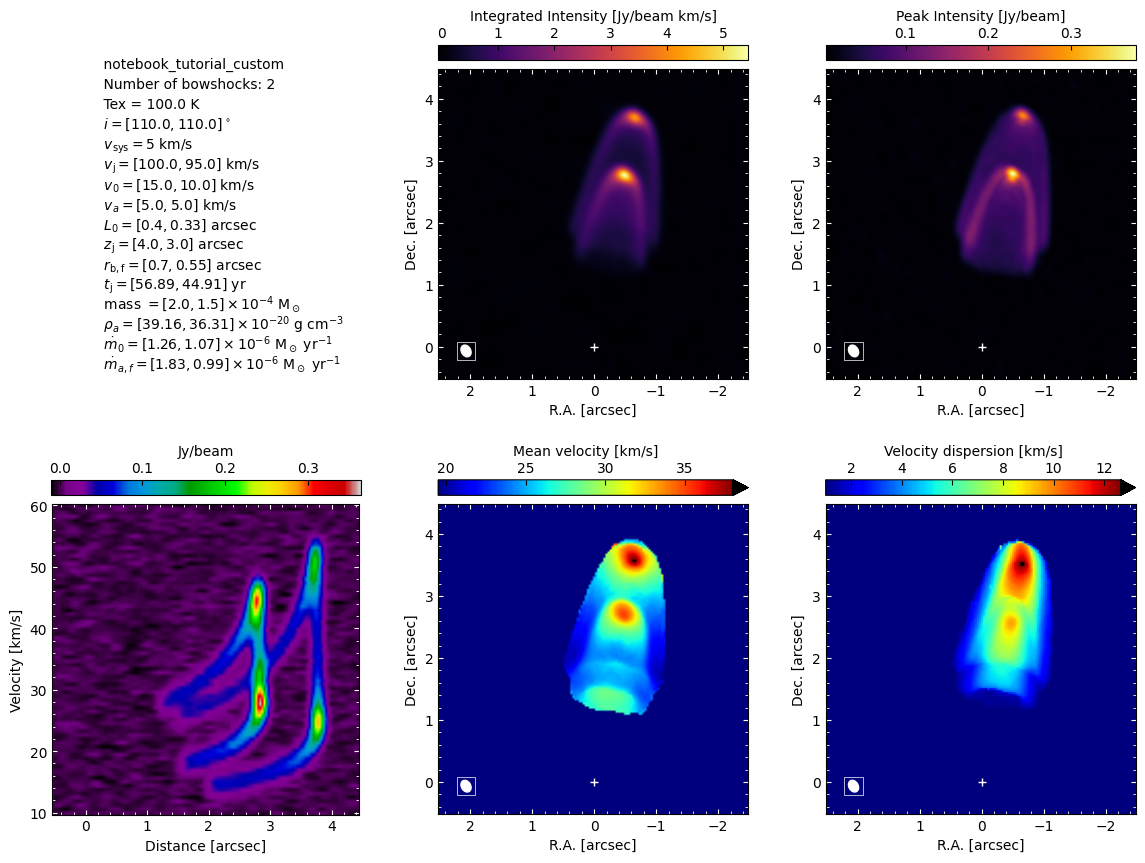

In [56]:
cubes_proc_custom.momentsandpv_and_params("I_nc", mom1clipping="5xsigma", mom2clipping="4xsigma", add_beam=True)

<a id="custommodel"></a>
## Appendix C: Custom model

This appendix shows how an advanced user can use BowshockPy to compute spectral cubes for a custom model. To define a custom model, the user should design a Python class containing methods that describe the morphology, kinematics and surface density of an axisymmetric shell model. As an example, we will compute the spectral cubes of a shell whose morphology and kinematics are based on Tafalla et al. (2017, A&A, 597, A119) geometric model of an internal jet shock. The model is a paraboloid, where the velocity field (in a reference frame comoving with the jet) is tangent to the surface and increases linearly from the apex to the edges.

In the following cell, we present an example that can be used as a template 

In [75]:
from bowshockpy import BaseModel
import bowshockpy.plots as pl

# The class should inherit from BaseModel class
class IWSModel(BaseModel):
    """
    Geometrical model of an internal working surface [1]

    Parameters
    ----------
    a : float
        Constant that controls the collimation of the paraboloid
    z0 : float
        z-coordinate (symmetry axis) of the apex of the paraboloid [km]
    zf : float
        z-coordinate (symmetry axis) of the edge of the paraboloid [km]
    vj : float
        velocity of the jet (z-component of the velocity of the paraboloid at
        the apex) [km/s]
    sigma_max : float
        Maximum density at the apex [solmass/km^2]
    distpc : float
        Distance to the source from the observer in pc

    References:
    -----------
    [1] Tafalla M., Su Y.-N., Shang H., Johnstone D., Zhang Q., Santiago-García
    J., Lee C.-F., et al., 2017, A&A, 597, A119.
    
    """

    def __init__(self, a, z0, zf, vf, vj, sigma_max, distpc):
        
        # distpc is a required attribute to instanciate BaseModel
        super().__init__(distpc)

        # Define the custom attributes used in the required methods
        self.a = a   # constant that controls the collimation of the paraboloid
        self.z0 = z0 # z-coordinate of the apex of the paraboloid
        self.zf = zf # z-coordinate of the edge of the paraboloid
        self.vf = vf # speed at the edge 
        self.vj = vj # velocity of the jet
        self.sigma_max = sigma_max # maximum density at the apex

        # Max radius of the model, attribute required by MassCube
        self.rbf = self.rb(zf) 

    # Method required by BowshockModelPlot, BowshockObsModelPlot, and ObsModel classes
    def rb(self, zb):
        """
        Radius of the model for a given z coordinate

        Parameters
        ----------
        zb : float
            z-coordinate [km]

        Returns
        -------
        float
            Shell radius at zb [km]
        """
        return np.sqrt(self.a**2 * self.z0 * (self.z0 - zb))

    # Not required by BowshockPy classes, used internally in methods in this class
    def v_tan(self, zb):
        """
        Computes the magnitude of the velocities tangent to the shell surface
        in the reference frame comoving with the jet
        
        Parameters
        ----------
        zb : float
            z-coordinate [km]

        Returns
        -------
        float
            Tangent velocity [km/s]
        """
        return self.vf / (self.z0-self.zf) * (self.z0-zb)

    # Not required by BowshockPy classes, used internally for methods in this class
    def tangent_angle(self, zb):
        """
        Angle between the (z0-z) axis and the tangent to the shell surface
        
        Parameters
        ----------
        zb : float
            z-coordinate

        Returns
        -------
        float
            Angle of the tangent to the shell surface [radians]
        """
        tanangle = np.arctan(0.5 * self.a**2 * self.z0 / self.rb(zb))
        return tanangle

    # Not required by BowshockPy classes, used internally for methods in this class
    def vz(self, zb):
        """
        Computes the longitudinal component of the velocity (along z-axis, the
        symmetry axis of the model)

        Parameters
        ----------
        zb : float
            z-coordinate [km]

        Returns
        -------
        float
            Longitudinal component of the velocity [km/s]
        """
        return self.vj - self.v_tan(zb) * np.cos(self.tangent_angle(zb))

    # Not required by BowshockPy classes, used internally for methods in this class
    def vr(self, zb):
        """
        Computes the radial component of the velocity (along r-axis,
        perpendicular symmetry axis of the model)

        Parameters
        ----------
        zb : float
            z coordinate [km]

        Returns
        -------
        float
            Transversal component of the velocity [km/s]
        """
        return self.v_tan(zb) * np.sin(self.tangent_angle(zb))

    # Method required by ObsModel class
    def velangle(self, zb):
        """
        Computes the angle between the velocity vector and the z-axis (symmetry
        axis)

        Parameters
        ----------
        zb : float
            z-coordinate [km]
        
        Returns
        -------
        float
            Angle between the velocity vector and the z-axis [radians]  
        """
        return np.arctan(self.vr(zb)/self.vz(zb))

    # Method required by BowshockModelPlot, BowshockModelObsPlot, ObsModel and MassCube classes
    def vtot(self, zb):
        """
        Computes the total speed of the velocity

        Parameters
        ----------
        zb : float
            z-coordinate [km]

        Returns
        -------
        float
            Speed of the model at zb [km/s]
        """
        return np.sqrt(self.vr(zb)**2 + self.vz(zb)**2)

    # Method required by BowshockModelPlot, BowshockObsModelPlot, and MassCube classes
    def zb_r(self, rr):
        """
        z-coordinate for a given radius of the model shell

        Parameters
        ----------
        rr : float
            Radius of the model shell [km]

        Returns
        -------
        float
            z-coordinate at radius rr [km]
        """
        return self.z0 - rr**2 / self.a**2 / self.z0

    # Method required by BowshockModelPlot class
    def surfdens(self, zb):
        """
        Surface density of the shell as a function of z-coordinate

        Parameters
        ----------
        zb : float
            z-coordinate [km]

        Returns
        -------
        float
            Surface density [solmass/km^2]
        """
        rr = self.rb(zb)
        if rr < self.rbf/2:
            sigma = self.sigma_max
        elif rr >= self.rbf/2:
            sigma = self.sigma_max * (2 * (self.rbf-rr)/self.rbf)**(1/2)
        return sigma

    # Method required by BowshockModelPlot, BowshockObsModelPlot, and MassCube classes
    def dz_func(self, zb, dr):
        """
        Differential dz at zb

        Parameters
        ----------
        zb : float
            z-coordinate [km]
        dr : float
            Differential or radius [km]

        Returns
        -------
        float
            Differential of z [km]
        """
        return 2 * self.rb(zb) / self.a**2 / self.z0 * dr
        # Alternatively
        # return self.zb_r(self.rb(zb)-dr/2) - self.zb_r(self.rb(zb)+dr/2)

    # Not required by BowshockPy classes, used internally for methods in this class
    def dsurf_func(self, zb, dz, dphi):
        """
        Differential of surface given a differential in z and phi

        Parameters
        ----------
        zb : float
            z-coordinate [km]
        dz : float
            Differential of z [km]
        dphi : phi
            Differential of azimuthal angle [radians]

        Returns
        -------
        float
            Differential surface density [solmass/km^2]

        """
        tana = (self.a**2*self.z0/2)
        rr = self.rb(zb)
        return np.sqrt(rr**2 + tana**2) * dz * dphi

    # Method required by MassCube class
    def dmass_func(self, zb, dz, dphi):
        """
        Differential of mass given a differential in z and phi

        Parameters
        ----------
        zb : float
            z-coordinate [km]
        dz : float
            Differential of z [km]
        dphi : phi
            Differential of azimuthal angle [radians]

        Returns
        -------
        float
            Differential of mass [Msun]
        """
        return self.surfdens(zb) * self.dsurf_func(zb, dz, dphi)

Once the custom class is defined, we can use the BowshockPy classes as we did for bowshock model

In [76]:
distpc = 300

modelname = "IWS"
a =  0.9
z0 = (4.0*distpc*u.au).to(u.km).value
zf = (3.8 * distpc * u.au).to(u.km).value
vf = 13.0
vj = 62.0
sigma_max = (10**(-3)*u.g*u.cm**(-2)).to(u.Msun*u.km**(-2)).value

iws = IWSModel(
    a=a,
    z0=z0,
    zf=zf,
    vf=vf,
    vj=vj,
    sigma_max=sigma_max,
    distpc=distpc,
)

/tmp/ipykernel_67027/578746701.py:98

(3.5, 5.5)

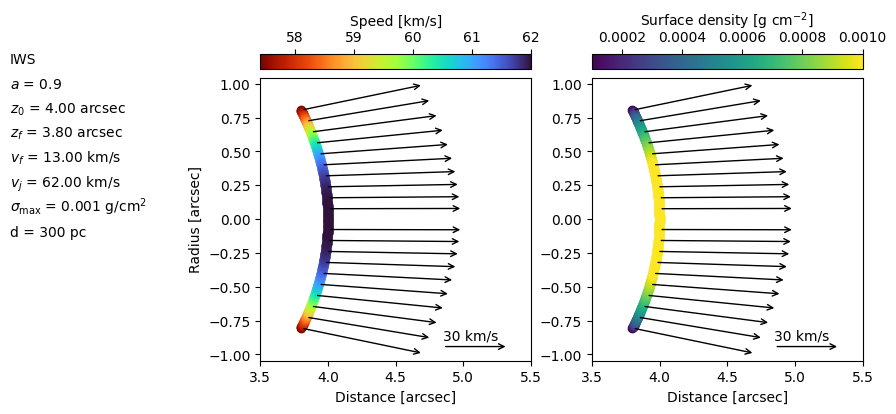

In [59]:
text_show = fr"""
{modelname}
$a$ = {iws.a}
$z_0$ = {iws.km2arcsec(iws.z0):.2f} arcsec
$z_f$ = {iws.km2arcsec(iws.zf):.2f} arcsec
$v_f$ = {iws.vf:.2f} km/s
$v_j$ = {iws.vj:.2f} km/s
$\sigma_\mathrm{{max}}$ = {iws.solMasskm2togcm2(iws.sigma_max):.2} g/cm$^2$
d = {distpc:.0f} pc
"""


iws_modelplot = pl.BowshockModelPlot(
    iws,
    modelname=modelname,
    figsize=(11,4),
    narrows=10,
    v_arrow_ref=30,
    linespacing=0.08,
    textbox_widthratio=0.7,
    gs_wspace=0.25
    )

iws_modelplot.plot(custom_showtext=text_show, normdens="linear")

iws_modelplot.axs[0].set_xlim([3.5, 5.5])
iws_modelplot.axs[1].set_xlim([3.5, 5.5])

In [85]:
iws_modelplot = pl.BowshockModelPlot(
    iws,
    modelname=modelname,
    figsize=(11,4),
    narrows=10,
    v_arrow_ref=30,
    linespacing=0.08,
    textbox_widthratio=0.7,
    gs_wspace=0.25
    )



/tmp/ipykernel_548722/578746701.py:98

In [77]:
obsiws = ObsModel(
    iws,
    i_deg = 38,
    pa_deg=25,
)

In [ ]:
obsiws_plot = obsiws.get_obsmodelplot()

/tmp/ipykernel_548722/578746701.py:98

/tmp/ipykernel_67027/578746701.py:98

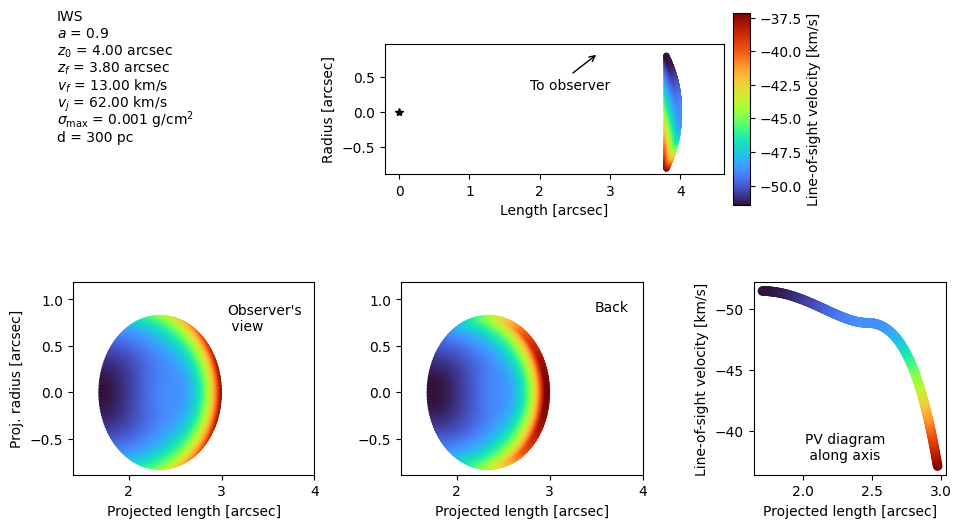

In [61]:
obsiws_plot = obsiws.get_obsmodelplot(
    modelname="IWS",
    figsize=(12, 6),
    x_obs_arrow=0.6,
    y_obs_arrow=0.8,
    )

obsiws_plot.plot(custom_showtext=text_show)
obsiws_plot.axs[1].set_xlim([1.4, 4])
obsiws_plot.axs[1].set_aspect("equal")
obsiws_plot.axs[2].set_xlim([1.4, 4])
obsiws_plot.axs[2].set_aspect("equal")

In [62]:
# Number of model points along the z-axis direction
nzs = 200

# Number of azimuthal angle phi for each z-axis point to calculate the bowshock solution
nphis = 600

# Number of spectral channel maps
nc = 60

# Central velocity of the first channel map [km/s]
vch0 = -55

# Central velocity of the last channel map [km/s]. Set to None if chanwidth is used.
vchf = -35 

# Width of the velocity channel [km/s]. If chanwidth>0, then vch0<vchf, if
# chanwidth<0, then vch0>vchf. Set to None if vchf is used.
chanwidth = None

# Number of pixels in the right ascension axis
nxs = 100

# Number of pixels in the declination axis
nys = 100

# Physical size of the channel maps along the x axis [arcsec]
xpmax = 4

# Thermal+turbulent line-of-sight velocity dispersion [km/s] 
# If thermal+turbulent line-of-sight velocity dispersion is smaller than the
# instrumental spectral resolution, vt should be the spectral resolution. It
# can be also set to a integer times the channel width, in this case it would be
# a string [e.g., "2xchannel"]
vt = "3xchannel"

# Set to true in order to perform a Cloud in Cell interpolation. If False,
# nearest neighbour point sampling will be performed [True/False]
cic = True

# Neighbour channel maps around a given channel map with vch will stop being
# populated when their difference in velocity with respect to vch is higher than
# this factor times vt. The lower the factor, the quicker will be the code, but
# the total mass will be underestimated. If vt is not None, compare the total
# mass of the output cube with the 'mass' parameter that the user has defined
tolfactor_vt = 3

# Reference pixel [[int, int] or None]
# Pixel coordinates (zero-based) of the source, i.e., the origin from which the
# distances are measured. The first index is the R.A. axis, the second is the
# Dec. axis.
refpix = [60, 10]

# Verbose messages about the computation? [True/False]
verbose = True


In [63]:
iws_cube = MassCube(
    obsiws,
    nphis=nphis,
    xpmax=xpmax,    
    vch0=vch0, 
    vchf=vchf,
    chanwidth=chanwidth,
    nzs=nzs,
    nc=nc,
    nxs=nxs,
    nys=nys, 
    refpix=refpix, 
    cic=cic,
    vt=vt,
    tolfactor_vt=tolfactor_vt,
    verbose=verbose,
    )

iws_cube.makecube()


Computing masses in the spectral cube...


/tmp/ipykernel_67027/578746701.py:98

  0──────────────────────────────────────────────────)100.0% | 24/24s


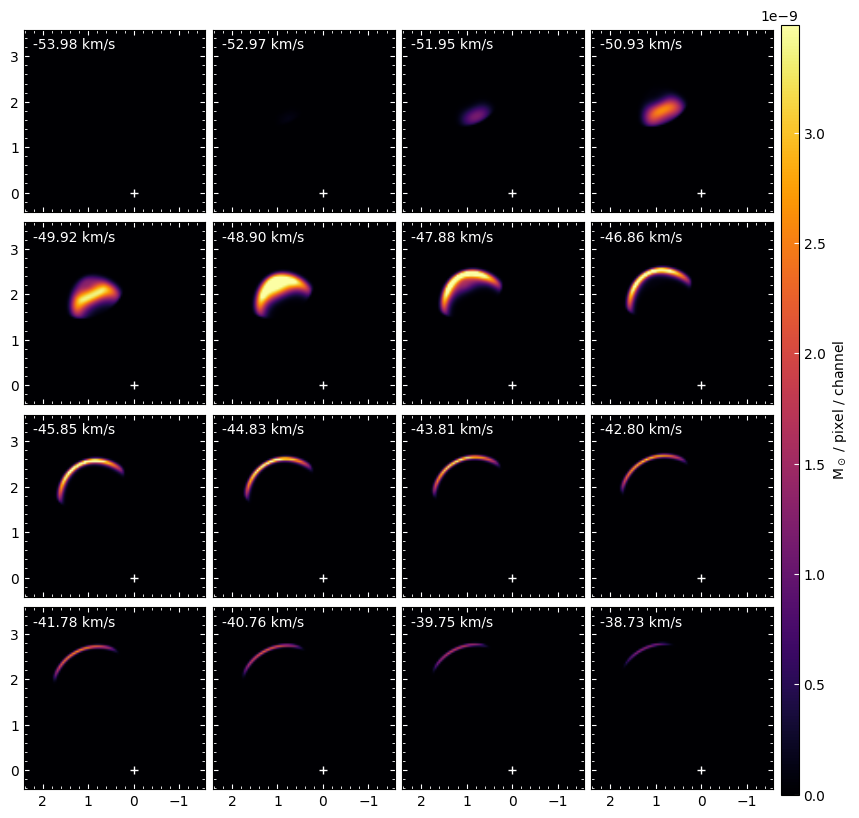

In [64]:
iws_cube.plot_channels(
    nrow=4, ncol=4, 
    vmax=np.percentile(iws_cube.cube, 99.9),
    )

In [65]:
# Source coordinates [deg, deg] 
ra_source_deg, dec_source_deg = 84.095, -6.7675

# Upper level of the CO rotational transition
J = 3

# Frequency of the transition [GHz]
nu = 345.79598990

# Emitting molecule abundance
abund = 8.5 * 10**(-5)

# Mean molecular mass per hydrogen molecule taking into account helium and
# metals that are heavier but less abundant than H2
meanmolmass = 2.8

# Permanent dipole moment [Debye]
mu = 0.112

# Excitation temperature [K]
Tex = 50

# Background temperature [K]
Tbg = 2.7

# Beam size [arcsec]
bmaj, bmin = (0.2, 0.1)

# Beam position angle [degrees]
pabeam = -20

# Spectral cubes in offset or sky coordinates? ["offset" or "sky"]
coordcube = "offset"

# Standard deviation of the noise of the map, before convolution. Set
# to None if maxcube2noise is used [Jy/beam]
sigma_beforeconv = 0.005

# Standard deviation of the noise of the map, before convolution, relative to
# the maximum pixel in the cube. The actual noise will be computed after
# convolving. This parameter would be used only if sigma_beforeconve is
# None.
maxcube2noise = 0.02

In [66]:
# astropy units are optional, and any units of the right quantity would work. If
# you use a float instead, you should give parameters in the specific units
# described in the comments from the cell above (see also input parameters from
# the documentation).
iwscubes_proc = CubeProcessing(
    [iws_cube], # we want to combine both models
    modelname="notebook_tutorial",
    J=J,
    nu=nu * u.GHz, 
    abund=abund,
    meanmolmass=meanmolmass,
    mu=mu * u.Debye,
    Tex=Tex * u.K,
    Tbg=Tbg * u.K,
    coordcube=coordcube,
    ra_source_deg=ra_source_deg,
    dec_source_deg = dec_source_deg,
    bmin=bmin,
    bmaj=bmaj,
    pabeam=pabeam,
    papv=iws_cube.pa_deg,
    sigma_beforeconv=sigma_beforeconv,
    maxcube2noise=maxcube2noise,
)

In [67]:
iwscubes_proc.calc_I()


Computing column densities...
The column densities have been calculated (Ntot cube)


Computing column densities of the emitting molecule...
The column densities of the emitting molecule have been calculated (Nmol cube)


Computing opacities...
The opacities have been calculated (tau cube)


Computing intensities...
The intensities have been calculated (I cube)



In [68]:
iwscubes_proc.convolve("I")


Convolving I... 
  0──────────────────────────────────────────────────)100.0% | 0/0s

I_c cube has been created by convolving I cube with a Gaussian kernel of
size [2.50, 5.00] pix and PA of -20.00deg





Computing moments and the PV-diagram along the jet axis


Rotatng I_c in order to compute the PV diagram...

I_cR cube has been created by rotating I_c cube an angle 115 deg to
compute the PV-diagram



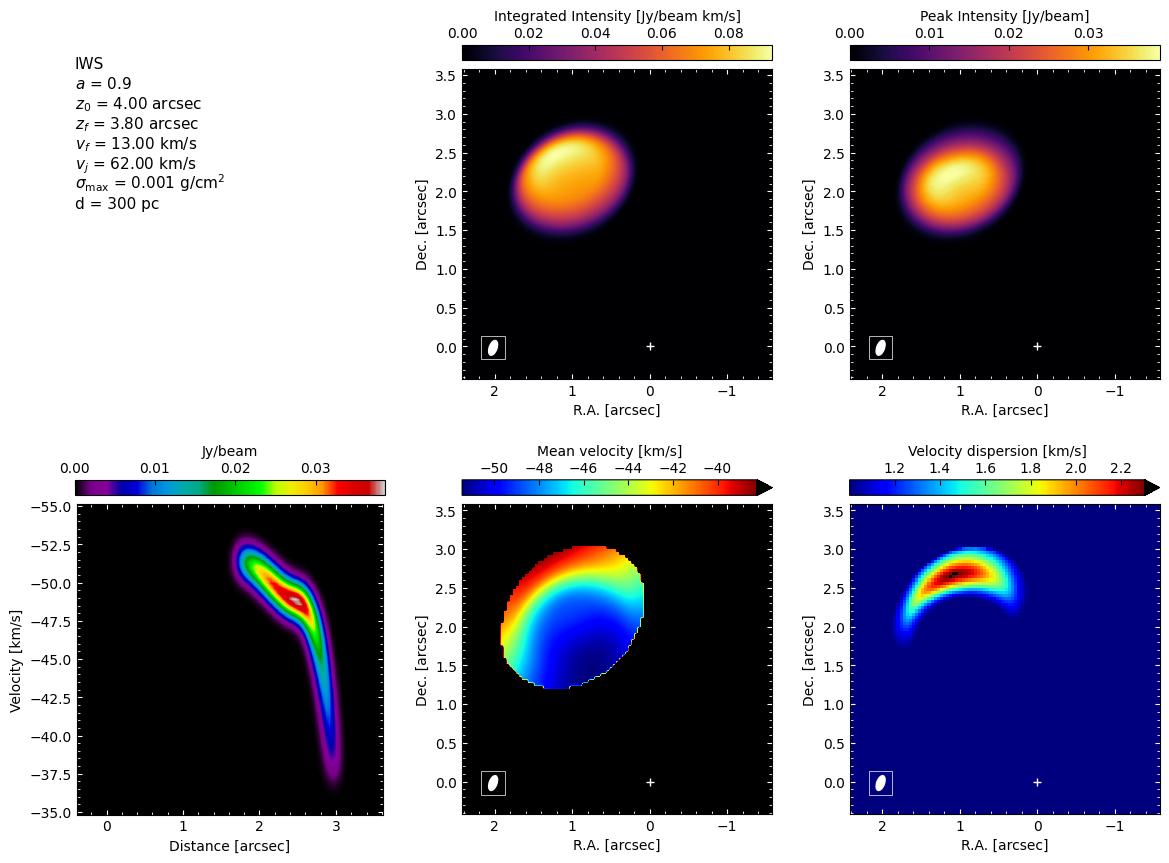

In [69]:
iwscubes_proc.momentsandpv_and_params(
    "I_c", custom_showtext=text_show, add_beam=True)

In [70]:
iwscubes_proc.add_noise("I")


Adding noise to I...

I_n cube has been created by adding Gaussian noise to I cube



In [71]:
iwscubes_proc.convolve("I_n")


Convolving I_n... 
  0──────────────────────────────────────────────────)100.0% | 0/0s

I_nc cube has been created by convolving I_n cube with a Gaussian kernel of
size [2.50, 5.00] pix and PA of -20.00deg


The rms of the convolved image is 0.00091412 Jy/beam



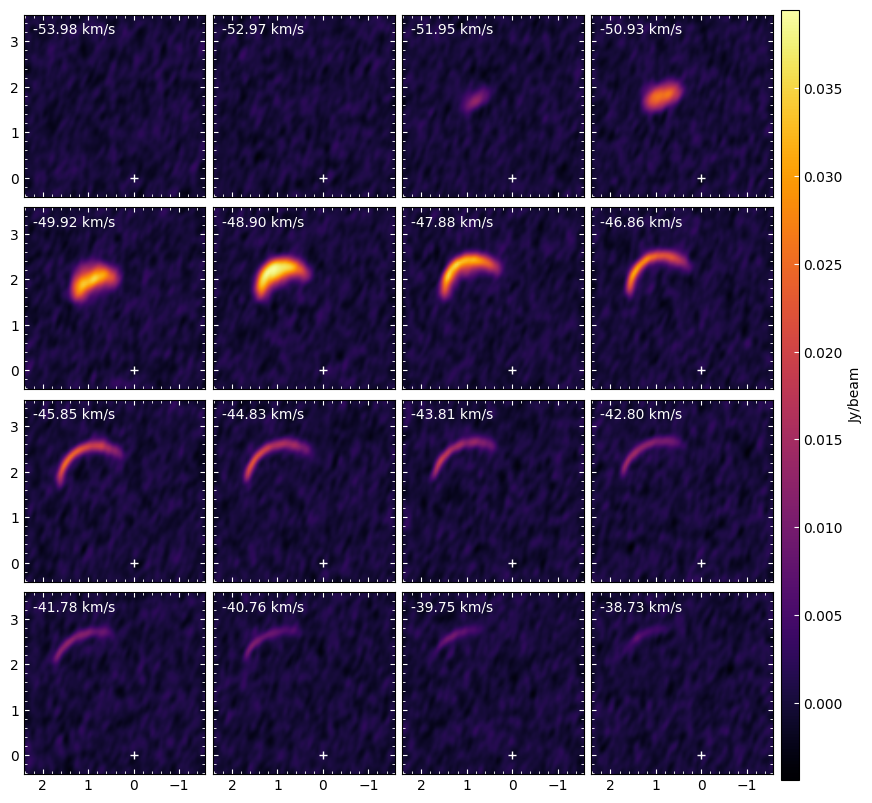

In [72]:
iwscubes_proc.plot_channels("I_nc")



Computing moments and the PV-diagram along the jet axis


Rotatng I_nc in order to compute the PV diagram...

I_ncR cube has been created by rotating I_nc cube an angle 115 deg to
compute the PV-diagram



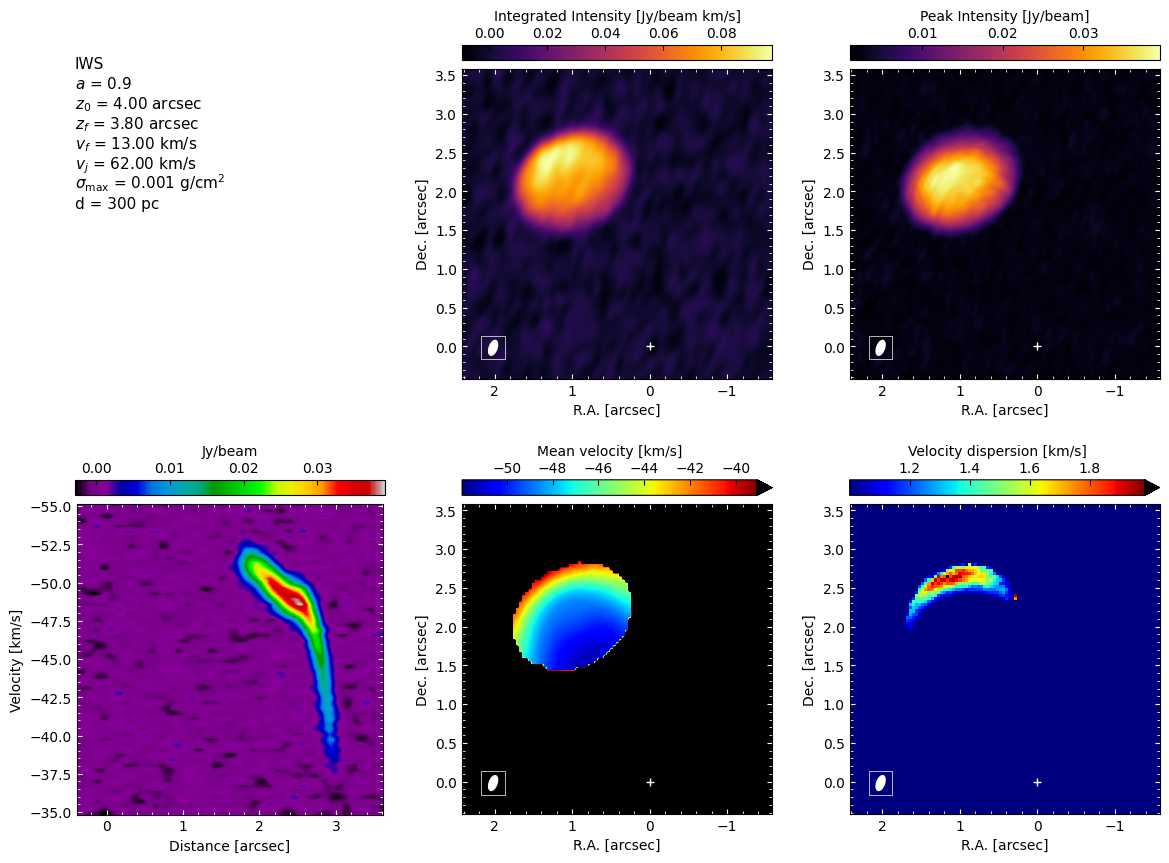

In [73]:
iwscubes_proc.momentsandpv_and_params(
    "I_nc", custom_showtext=text_show, add_beam=True,
 mom1clipping="5xsigma", mom2clipping="4xsigma", 
)